In [1]:
# changing core directory
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('..')

In [2]:
import copy

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

from src.data import load_data, transform_data, MyDataset
from src.attacks import attack_procedure
from src.utils import save_experiment, load_disc_model
from src.config import get_attack, load_disc_config

from src.models.LSTM import LSTM
from src.attacks import deepfool_attack, fgsm_attack, only_disc_attack

from src.attacks.utils import calculate_metrics_class_and_hiddens, req_grad

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [3]:
dataset = 'FordA'

cfg = {
    'slice': True,
    'dataset': dataset,
    'batch_size': 256,
    'cuda': 'cuda:1',
    'train_mode': True,
    'model_folder': f'checkpoints/{dataset}/LSTM/',
    "model_id_attack": 0,
    "model_id": 1,
    "disc_check_params":{
        'model_id' : 0,
        'model_name':"fgsm_attack_eps=0.03_nsteps=10",
    },

    'list_reg_model_params': [{
        'model_id' : 0,
        'model_name':"fgsm_attack_eps=0.03_nsteps=10",
    }],

    # 'list_reg_model_params': [
    #     {'model_id' : 0, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=1_nsteps=10',},
    #     {'model_id' : 0, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=10_nsteps=10',},
    #     {'model_id' : 1, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=1_nsteps=10',},
    #     {'model_id' : 1, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=10_nsteps=10',},
    #     {'model_id' : 2, 'model_name':'fgsm_disc_attack2_eps=0.03_alpha=1_nsteps=10',},
    # ],
    "disc_path": "results/FordA/LSTM/discriminator/fgsm_attack_SAVE_TEST",
    'use_extra_sigmoid': False,
}

alpha = 0.001
criterion = torch.nn.BCELoss()

In [4]:
X_train, y_train, X_test, y_test = load_data(cfg['dataset'])
X_train, X_test, y_train, y_test = transform_data(X_train, X_test, y_train, y_test, slice_data=cfg['slice'])

test_loader = DataLoader(
    MyDataset(X_test, y_test), 
    batch_size=cfg['batch_size'] , 
    shuffle=True
    )

device= torch.device(cfg['cuda'] if torch.cuda.is_available() else 'cpu')

model = LSTM(
    hidden_dim = 50,
    n_layers = 1,
    output_dim = 1,
    dropout = 0.0,
).to(device)

model_path = cfg['model_folder'] + f'model_{cfg["model_id_attack"]}_{cfg["dataset"]}.pth'
model.load_state_dict(copy.deepcopy(torch.load(model_path)))

model.train(cfg['train_mode'])

LSTM(
  (rnn): LSTM(1, 50, batch_first=True)
  (fc1): Linear(in_features=50, out_features=50, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (tanh): Tanh()
)

In [5]:
disc_model_check = LSTM(
    hidden_dim = 50,
    n_layers = 1,
    output_dim = 1,
    dropout = 0.0,
).to(device)

disc_model_check = load_disc_model(
    copy.deepcopy(disc_model_check),
    model_id=cfg['disc_check_params']['model_id'], 
    path=cfg['disc_path'], 
    model_name=cfg['disc_check_params']['model_name'], 
    device=device,
    )
disc_model_check.train(cfg['train_mode'])


disc_model = LSTM(
    hidden_dim = 50,
    n_layers = 1,
    output_dim = 1,
    dropout = 0.0,
)

In [11]:
disc_models_list = load_disc_config(
    copy.deepcopy(disc_model),
    cfg['disc_path'], 
    device, 
    cfg['list_reg_model_params'],
    train_mode=cfg['train_mode']
)  

In [13]:
x, y = next(iter(test_loader))
x = x.to(device)

disc_models_list[0](x)[:10]

tensor([[1.1399e-03],
        [6.5811e-05],
        [4.6825e-04],
        [2.3547e-05],
        [5.9501e-04],
        [4.4208e-04],
        [4.9783e-05],
        [1.1726e-05],
        [4.7945e-04],
        [1.3513e-03]], device='cuda:1', grad_fn=<SliceBackward0>)

# iterations -> loader

### ill

In [16]:
attack_params = dict()
attack_params['eps'] = 0.005
#attack_params['alpha'] = alpha
# attack_params['disc_models'] = load_disc_config(
#     copy.deepcopy(disc_model),
#     cfg['disc_path'], 
#     device, 
#     cfg['list_reg_model_params'],
#     train_mode=cfg['train_mode']
# )  
#attack_params['use_sigmoid'] = cfg['use_extra_sigmoid']

In [17]:
n_steps_attack = 10
log_iters = np.zeros(len(test_loader))
dataset_class = test_loader.dataset.__class__

n_broken = 0
metric_fun = calculate_metrics_class_and_hiddens

results_dict = {}

for step in tqdm(range(n_steps_attack)):
    model.train(cfg['train_mode'])
    req_grad(model, state=False)
    
    all_y_true = torch.tensor([])  # logging model for rebuilding dataloader and calculation difference with preds
    x_tensor = torch.FloatTensor([])
    all_preds = []
    
    for i, (x, y_true) in enumerate(test_loader):
        all_y_true = torch.cat((all_y_true, y_true.cpu().detach()), dim=0)
        # print(f'OBJECT {i}')
        x.grad = None
        x.requires_grad = True
        
        y_true = y_true.to(device)
        y_pred = y_true.clone()
        x = x.to(device)

        y_pred = model(x)

        x_adv = fgsm_attack(model, criterion, x, y_true, **attack_params)
        x_tensor = torch.cat((x_tensor, x_adv.cpu().detach()), dim=0)

        with torch.no_grad(): # prediction for adv input
            y_pred_adv = model(x_adv)
        all_preds.extend(y_pred_adv.cpu().detach().data.numpy())


    preds_flat_round = np.round(np.array(all_preds)).flatten()
    y_true_flat = all_y_true.cpu().detach().numpy().flatten()
    results_dict[step] = metric_fun(y_true_flat, preds_flat_round, x, disc_model_check)

    it_dataset = dataset_class(x_tensor, torch.tensor(all_y_true))
    test_loader = DataLoader(it_dataset, batch_size=cfg['batch_size'])
        

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy:  0.7295454545454545
Accuracy:  0.6968181818181818
Accuracy:  0.66
Accuracy:  0.6246969696969698
Accuracy:  0.5883333333333334
Accuracy:  0.5490909090909091
Accuracy:  0.5071212121212121
Accuracy:  0.4696969696969697
Accuracy:  0.43446969696969695
Accuracy:  0.4041666666666667


### doctor

In [18]:
attack_params['alpha'] = alpha
attack_params['disc_models'] = load_disc_config(
    copy.deepcopy(disc_model),
    cfg['disc_path'], 
    device, 
    cfg['list_reg_model_params'],
    train_mode=cfg['train_mode']
)  
#attack_params['use_sigmoid'] = cfg['use_extra_sigmoid']

In [19]:
for step in tqdm(range(step, n_steps_attack + step)):
    model.train(cfg['train_mode'])
    req_grad(model, state=False)
    
    all_y_true = torch.tensor([])  # logging model for rebuilding dataloader and calculation difference with preds
    x_tensor = torch.FloatTensor([])
    all_preds = []
    
    for i, (x, y_true) in enumerate(test_loader):
        all_y_true = torch.cat((all_y_true, y_true.cpu().detach()), dim=0)
        # print(f'OBJECT {i}')
        x.grad = None
        x.requires_grad = True
        
        y_true = y_true.to(device)
        y_pred = y_true.clone()
        x = x.to(device)

        y_pred = model(x)

        x_adv = only_disc_attack(model, criterion, x, y_true, **attack_params)
        x_tensor = torch.cat((x_tensor, x_adv.cpu().detach()), dim=0)

        with torch.no_grad(): # prediction for adv input
            y_pred_adv = model(x_adv)
        all_preds.extend(y_pred_adv.cpu().detach().data.numpy())

    preds_flat_round = np.round(np.array(all_preds)).flatten()
    y_true_flat = all_y_true.cpu().detach().numpy().flatten()
    results_dict[step] = metric_fun(y_true_flat, preds_flat_round, x, disc_model_check)

    it_dataset = dataset_class(x_tensor, torch.tensor(all_y_true))
    test_loader = DataLoader(it_dataset, batch_size=cfg['batch_size'])

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy:  0.40234848484848484
Accuracy:  0.40015151515151515
Accuracy:  0.3984848484848485
Accuracy:  0.39825757575757575
Accuracy:  0.3987121212121212
Accuracy:  0.3997727272727273
Accuracy:  0.39984848484848484
Accuracy:  0.3993939393939394
Accuracy:  0.3997727272727273
Accuracy:  0.39924242424242423


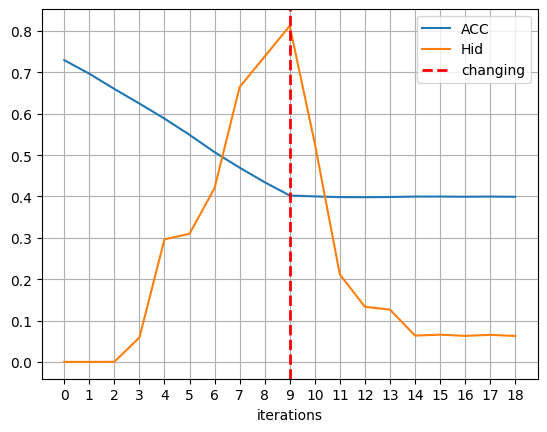

In [20]:
df_res = pd.DataFrame(results_dict).T
df_res.columns = ['ACC', 'ROC_AUC', 'PR_AUC', 'Hid']

#df_res[['ACC', 'Hid']].plot()
plt.plot(df_res['ACC'], label='ACC')
plt.plot(df_res['Hid'], label='Hid')
plt.axvline(9, label='changing', c='red', linestyle='--', linewidth=2)
plt.legend()
plt.grid()
plt.xlabel('iterations')
plt.xticks(range(19))
plt.show()

In [22]:
df_res.iloc[-1]

ACC          0.399242
ROC_AUC      0.394773
PR_AUC       0.447257
Hid        0.06283137
Name: 18, dtype: object

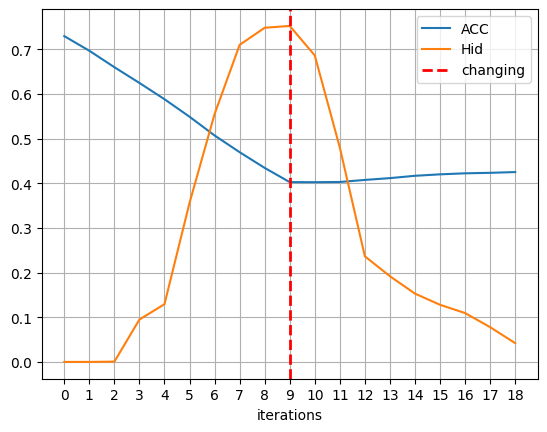

In [11]:
df_res = pd.DataFrame(results_dict).T
df_res.columns = ['ACC', 'ROC_AUC', 'PR_AUC', 'Hid']

#df_res[['ACC', 'Hid']].plot()
plt.plot(df_res['ACC'], label='ACC')
plt.plot(df_res['Hid'], label='Hid')
plt.axvline(9, label='changing', c='red', linestyle='--', linewidth=2)
plt.legend()
plt.grid()
plt.xlabel('iterations')
plt.xticks(range(19))
plt.show()